In [1]:
######################################################################################################
## Etapa 0: Importando as bibliotecas necessárias
######################################################################################################
import os
import time
import random

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image, display_image
from src.modules.detection import Detection, display_image_with_detections
from src.modules.canny import Canny, display_canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path
from src.modules.sort_points import SortPoints, plot_sorted_points
from src.modules.compute_splines import ComputeSplines, plot_splines
random.seed(42)  # For reproducibility

In [2]:
def process_image(file_path):
    try:
        start_step1 = time.time()
        print("Etapa 1: Leitura da imagem")
        img = Image(file_path)
        img.reading_image()
        end_step1 = time.time()


        # Etapa 2: Detecção de características
        print("Etapa 2: Detecção de características")
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        end_step2 = time.time()
        # print(detection.nose.x, detection.nose.y)


        # Etapa 3: Detecção de bordas
        print("Etapa 3: Detecção de bordas")
        canny = Canny(detection.mouth.img, detection.mouth.x, detection.mouth.y,
                      detection.nose.img, detection.nose.x, detection.nose.y,
                      detection.left_eye.img, detection.left_eye.x, detection.left_eye.y,
                      detection.right_eye.img, detection.right_eye.x, detection.right_eye.y,
                      detection.mid_point)
        canny.compute_all_edges()
        end_step3 = time.time()


        # Etapa 4: Criação das matrizes de adjacência
        print("Etapa 4: Criação das matrizes de adjacência")
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()
        end_step4 = time.time()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        print("Etapa 5: Cálculo de componentes conectados para cada matriz")
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()
        end_step5 = time.time()
        # Etapa 6: Cálculo da árvore geradora mínima
        print("Etapa 6: Cálculo da árvore geradora mínima")
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()
        end_step6 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 7: Construção da árvore e poda")
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        end_step7 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 8: Ordenando os pontos")
        sort = SortPoints(tree.new_longest_path_nose, tree.new_longest_path_mouth, tree.new_longest_path_left_eye, tree.new_longest_path_right_eye,
                          mst.nodes_nose, mst.nodes_mouth, mst.nodes_left_eye, mst.nodes_right_eye,
                          canny.nose_dict, canny.mouth_dict, canny.left_eye_dict, canny.right_eye_dict)
        sort.compute_all_coordenates()


        # Etapa 8: Splines
        print("Etapa 8: Splines")
        splines = ComputeSplines(sort.sorted_coord_nose, sort.sorted_coord_mouth, sort.sorted_coord_left_eye, sort.sorted_coord_right_eye)
        splines.compute_all_splines()
        end_step8 = time.time()


        return img, detection, canny, adjacency_matrix, components_results, mst, tree, sort, splines

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './unzip_images'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.ppm'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))
    # quero guardar os 3 primeiros strings do file_path
    tag = [os.path.basename(file_path).split('.')[0].split('_')[0] for file_path in file_paths]

    results_tag = []
    for i in range(len(results)):
        if results[i] is not None:
            results_tag.append((f"{tag[i]}_{i}", results[i]))



Etapa 1: Leitura da imagem
Etapa 1: Leitura da imagem
Etapa 1: Leitura da imagem
Etapa 1: Leitura da imagem
Etapa 1: Leitura da imagem
Etapa 2: Detecção de características
Etapa 2: Detecção de características
Etapa 2: Detecção de características
Etapa 2: Detecção de características
Etapa 2: Detecção de características
Etapa 3: Detecção de bordas
Etapa 4: Criação das matrizes de adjacência
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 6: Cálculo da árvore geradora mínima
Etapa 7: Construção da árvore e poda
Etapa 8: Ordenando os pontos
Etapa 8: Splines
Etapa 1: Leitura da imagem
Etapa 2: Detecção de características
Etapa 3: Detecção de bordas
Etapa 4: Criação das matrizes de adjacência
Etapa 3: Detecção de bordas
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 4: Criação das matrizes de adjacência
Etapa 3: Detecção de bordas
Etapa 3: Detecção de bordas
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 4: Criação das matrizes de adjac

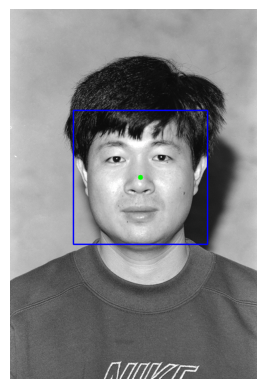

In [3]:
display_image_with_detections(results[0][0].image, results[0][1].face, results[0][1].nose, results[0][1].mouth, results[0][1].left_eye, results[0][1].right_eye)

In [4]:
import numpy as np

def points(left_eye_x, right_eye_x, nose_x, mouth_x,
           left_eye_y, right_eye_y, nose_y, mouth_y):
    # Adiciona os pontos da boca
    le1 = np.concatenate([arr.flatten() for arr in left_eye_x]).tolist()
    re1 = np.concatenate([arr.flatten() for arr in right_eye_x]).tolist()
    m1 = np.concatenate([arr.flatten() for arr in mouth_x]).tolist()
    n1 = np.concatenate([arr.flatten() for arr in nose_x]).tolist()

    x1 = np.concatenate([le1, re1, m1, n1]).tolist()

    le1 = np.concatenate([arr.flatten() for arr in left_eye_y]).tolist()
    re1 = np.concatenate([arr.flatten() for arr in right_eye_y]).tolist()
    m1 = np.concatenate([arr.flatten() for arr in mouth_y]).tolist()
    n1 = np.concatenate([arr.flatten() for arr in nose_y]).tolist()

    y1 = np.concatenate([le1, re1, m1, n1]).tolist()
    points1 = list(zip(x1, y1))

    return points1

In [5]:
import pandas as pd
df_people_points = pd.DataFrame(columns=['tag', 'points'])

for i in range(len(results_tag)):
    teste = points(results_tag[i][1][8].all_X_left_eye, 
                results_tag[i][1][8].all_X_right_eye,
                results_tag[i][1][8].all_X_nose,
                results_tag[i][1][8].all_X_mouth,
                results_tag[i][1][8].all_Y_left_eye,
                results_tag[i][1][8].all_Y_right_eye,
                results_tag[i][1][8].all_Y_nose,
                results_tag[i][1][8].all_Y_mouth)
    tag = results_tag[i][0]
    df_people_points = pd.concat([df_people_points, pd.DataFrame({'tag': [tag], 'points': [teste]})], ignore_index=True)


In [6]:
def dtw_2d_curve(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(np.array(series1[i-1]) - np.array(series2[j-1]))
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # inserção
                dtw_matrix[i, j - 1],    # remoção
                dtw_matrix[i - 1, j - 1] # match
            )

    return dtw_matrix[n, m]

In [7]:
import pandas as pd
import numpy as np

# Cria a matriz de distâncias vazia
unique_ids = df_people_points["tag"].tolist()
df_distances = pd.DataFrame(index=unique_ids, columns=unique_ids, dtype=float)

# Preenche apenas a parte superior da matriz
for i in range(len(df_people_points)):
    for j in range(i + 1, len(df_people_points)):
        uid_i = df_people_points["tag"].iloc[i]
        uid_j = df_people_points["tag"].iloc[j]

        # print(f"Comparando {uid_i} e {uid_j}")
        distance = dtw_2d_curve(df_people_points["points"].iloc[i],
                                df_people_points["points"].iloc[j])
        # print(f"DTW distance (2D curves): {distance:.4f}")

        df_distances.loc[uid_i, uid_j] = distance


In [11]:
# Espelha a parte superior para preencher a inferior
df_distances = df_distances.combine_first(df_distances.T)

# Remove a diagonal (opcional: substitui por NaN)
np.fill_diagonal(df_distances.values, np.nan)

# Encontra o menor valor de cada linha (ignorando a diagonal)
min_values = df_distances.min(axis=1)
min_columns = df_distances.idxmin(axis=1)

# Junta em DataFrame final
df_min = pd.DataFrame({
    "unique_id": df_distances.index,
    "closest_id": min_columns,
    "min_distance": min_values
}).reset_index(drop=True)

In [12]:
# passo:0.5, tensão: 0.5
df_min

,unique_id,closest_id,min_distance
0,00029_0,00029_1,11018.637080
1,00029_1,00029_7,2433.859410
2,00029_2,00146_13,5571.768817
3,00029_3,00029_5,11266.952994
4,00029_4,00732_21,6874.642915
5,00029_5,00146_17,3669.286543
6,00029_6,00029_7,2992.809681
7,00029_7,00029_1,2433.859410
8,00029_8,00732_21,3133.398049
9,00029_9,00732_19,7736.981229


In [13]:
df_min["closest_id"] = df_min["closest_id"].str[:5] 
df_min["unique_id"] = df_min["unique_id"].str[:5] 

matches = df_min[df_min["unique_id"] == df_min["closest_id"]]
len(matches) / len(df_min) * 100

33.33333333333333

In [ ]:
# passo: 0.1, tensão: 1
df_min

,unique_id,closest_id,min_distance
0,00029_0,00029_1,59607.970031
1,00029_1,00029_7,12785.414126
2,00029_2,00029_1,31165.038574
3,00029_3,00146_15,70403.622510
4,00029_4,00146_16,38371.793510
5,00029_5,00029_6,26232.964239
6,00029_6,00029_7,16067.471326
7,00029_7,00029_1,12785.414126
8,00029_8,00732_21,23931.130974
9,00029_9,00732_19,41576.256458


In [ ]:
# passo: 0.5, tensão: 1
df_min

,unique_id,closest_id,min_distance
0,00029_0,00029_1,16299.366692
1,00029_1,00029_7,3574.619374
2,00029_2,00029_1,8484.292870
3,00029_3,00029_5,16745.846890
4,00029_4,00029_5,10042.563863
5,00029_5,00029_6,5951.994949
6,00029_6,00029_7,4457.899528
7,00029_7,00029_1,3574.619374
8,00029_8,00732_21,4806.122714
9,00029_9,00732_19,11490.109809
